# Multiple Objectives for Residential PV

## Set up.

### One only needs to execute the following line once, in order to make sure recent enough packages are installed.

In [1]:
#!pip install 'numpy>=1.17.2' 'pandas>=0.25.1'

### Import packages.

In [2]:
import os
import sys
sys.path.insert(0, os.path.abspath("../src"))

In [3]:
import numpy             as np
import matplotlib.pyplot as pl
import pandas            as pd
import re                as re
import scipy.stats       as st
import seaborn           as sb

# The `tyche` package is located at <https://github.com/NREL/portfolio/tree/master/production-function/framework/src/tyche/>.
import tyche             as ty

from copy import deepcopy

## Load data.

### The data are stored in a set of tab-separated value files in a folder.

In [4]:
designs = ty.Designs("../data/residential_pv_multiobjective")

In [5]:
investments = ty.Investments("../data/residential_pv_multiobjective")

### Compile the production and metric functions for each technology in the dataset.

In [6]:
designs.compile()

## Examine the data.

### The `functions` table specifies where the Python code for each technology resides.

In [7]:
designs.functions

,Style,Module,Capital,Fixed,Production,Metrics,Notes
Technology,,,,,,,
Residential PV,numpy,residential_pv_multiobjective,capital_cost,fixed_cost,production,metrics,


Right now, only the style `numpy` is supported.

### The `indices` table defines the subscripts for variables.

In [8]:
designs.indices

Offset  \
Technology     Type    Index                 
Residential PV Capital BoS               2   
                       Inverter          1   
                       Module            0   
               Fixed   System            0   
               Input   NaN               0   
               Metric  GHG               2   
                       LCOE              0   
                       Labor             1   
               Output  Electricity       0   

                                                              Description  \
Technology     Type    Index                                                
Residential PV Capital BoS                              balance of system   
                       Inverter                          system inverters   
                       Module                               system module   
               Fixed   System                                whole system   
               Input   NaN                                      no inputs   
               Metric  GHG                              reduction in GHGs   
                       LCOE         reduction in levelized cost of energy   
                       Labor                increase in spending on wages   
               Output  Electricity                  electricity generated   

                                   Notes  
Technology     Type    Index              
Residential PV Capital BoS                
                       Inverter           
                       Module             
               Fixed   System             
               Input   NaN                
               Metric  GHG                
                       LCOE               
                       Labor              
               Output  Electricity

### The `designs` table contains the cost, input, efficiency, and price data for a scenario.

In [9]:
designs.designs

Value  \
Technology     Scenario             Variable          Index               
Residential PV 2015 Actual          Input             NaN             0   
                                    Input efficiency  NaN             1   
                                    Input price       NaN             0   
                                    Lifetime          BoS             1   
                                                      Inverter        1   
...                                                                 ...   
               Module Slow Progress Lifetime          Inverter        1   
                                                      Module          1   
                                    Output efficiency Electricity     1   
                                    Output price      Electricity     0   
                                    Scale             NaN             1   

                                                                             Units  \
Technology     Scenario             Variable          Index                          
Residential PV 2015 Actual          Input             NaN                        1   
                                    Input efficiency  NaN                        1   
                                    Input price       NaN                        1   
                                    Lifetime          BoS          system-lifetime   
                                                      Inverter     system-lifetime   
...                                                                            ...   
               Module Slow Progress Lifetime          Inverter     system-lifetime   
                                                      Module       system-lifetime   
                                    Output efficiency Electricity              W/W   
                                    Output price      Electricity            $/kWh   
                                    Scale             NaN            system/system   

                                                                                                             Notes  
Technology     Scenario             Variable          Index                                                         
Residential PV 2015 Actual          Input             NaN                                                no inputs  
                                    Input efficiency  NaN                                                no inputs  
                                    Input price       NaN                                                no inputs  
                                    Lifetime          BoS                                per-lifetime computations  
                                                      Inverter                           per-lifetime computations  
...                                                                                                            ...  
               Module Slow Progress Lifetime          Inverter                           per-lifetime computations  
                                                      Module                             per-lifetime computations  
                                    Output efficiency Electricity  see parameter table for individual efficiencies  
                                    Output price      Electricity                   not tracking electricity price  
                                    Scale             NaN                                               no scaling  

[90 rows x 3 columns]

### The `parameters` table contains additional techno-economic parameters for each technology.

In [10]:
designs.parameters

Offset  \
Technology     Scenario             Parameter                      
Residential PV 2015 Actual          Customer Acquisition      19   
                                    DC-to-AC Ratio            15   
                                    Direct Labor              17   
                                    Discount Rate              0   
                                    Hardware Capital          16   
...                                                          ...   
               Module Slow Progress Module Lifetime            4   
                                    Module O&M Fixed           7   
                                    Module Soiling Loss       10   
                                    Permitting                18   
                                    System Size                2   

                                                                                           Value  \
Technology     Scenario             Parameter                                                      
Residential PV 2015 Actual          Customer Acquisition     st.triang(0.5, loc=2000, scale=0.2)   
                                    DC-to-AC Ratio        st.triang(0.5, loc=1.4, scale=0.00014)   
                                    Direct Labor             st.triang(0.5, loc=2000, scale=0.2)   
                                    Discount Rate                                           0.07   
                                    Hardware Capital         st.triang(0.5, loc=80, scale=0.008)   
...                                                                                          ...   
               Module Slow Progress Module Lifetime              st.triang(0.5, loc=26, scale=1)   
                                    Module O&M Fixed           st.triang(0.5, loc=19, scale=0.5)   
                                    Module Soiling Loss   st.triang(0.5, loc=0.05, scale=10E-06)   
                                    Permitting               st.triang(0.5, loc=600, scale=0.06)   
                                    System Size                                               36   

                                                             Units Notes  
Technology     Scenario             Parameter                             
Residential PV 2015 Actual          Customer Acquisition  $/system   BCA  
                                    DC-to-AC Ratio               1   IDC  
                                    Direct Labor          $/system   BLR  
                                    Discount Rate           1/year    DR  
                                    Hardware Capital         $/m^2   BCC  
...                                                            ...   ...  
               Module Slow Progress Module Lifetime             yr   MLT  
                                    Module O&M Fixed        $/kWyr   MOM  
                                    Module Soiling Loss          1   MSL  
                                    Permitting            $/system   BPR  
                                    System Size                m^2   SSZ  

[210 rows x 4 columns]

### The `results` table specifies the units of measure for results of computations.

In [11]:
designs.results

Units Notes
Technology     Variable Index                           
Residential PV Cost     Cost              $/system      
               Metric   GHG          ΔgCO2e/system      
                        LCOE                Δ$/kWh      
                        Labor            Δ$/system      
               Output   Electricity            kWh

### The `tranches` table specifies multually exclusive possibilities for investments: only one `Tranch` may be selected for each `Category`.

In [12]:
investments.tranches

Amount Notes
Category     Tranche             Scenario                                   
BoS R&D      BoS High R&D        Bos Fast Progress            900000.0      
             BoS Low R&D         BoS Slow Progress            300000.0      
             BoS Medium R&D      Bos Moderate Progress        600000.0      
Inverter R&D Inverter High R&D   Inverter Fast Progress      3000000.0      
             Inverter Low R&D    Inverter Slow Progress      1000000.0      
             Inverter Medium R&D Inverter Moderate Progress  2000000.0      
Module R&D   Module High R&D     Module Fast Progress        4500000.0      
             Module Low R&D      Module Slow Progress        1500000.0      
             Module Medium R&D   Module Moderate Progress    3000000.0

### The `investments` table bundles a consistent set of tranches (one per category) into an overall investment.

In [13]:
investments.investments

Notes
Investment Category     Tranche                  
High R&D   BoS R&D      BoS High R&D             
           Inverter R&D Inverter High R&D        
           Module R&D   Module High R&D          
Low R&D    BoS R&D      BoS Low R&D              
           Inverter R&D Inverter Low R&D         
           Module R&D   Module Low R&D           
Medium R&D BoS R&D      BoS Medium R&D           
           Inverter R&D Inverter Medium R&D      
           Module R&D   Module Medium R&D

## Evaluate the scenarios in the dataset.

In [14]:
scenario_results = designs.evaluate_scenarios(sample_count=50)

In [15]:
scenario_results.xs(1, level="Sample", drop_level=False)

Value  \
Technology     Scenario                   Sample Variable Index                        
Residential PV 2015 Actual                1      Cost     Cost          19539.227944   
                                                 Metric   GHG              -0.004906   
                                                          LCOE             -0.000009   
                                                          Labor            -0.009447   
                                                 Output   Electricity  184100.029294   
               BoS Fast Progress          1      Cost     Cost          17560.275391   
                                                 Metric   GHG              -0.002930   
                                                          LCOE              0.010743   
                                                          Labor          -484.964445   
                                                 Output   Electricity  184104.428731   
               BoS Moderate Progress      1      Cost     Cost          17930.790363   
                                                 Metric   GHG              -0.008140   
                                                          LCOE              0.008724   
                                                          Labor          -355.032086   
                                                 Output   Electricity  184092.828163   
               BoS Slow Progress          1      Cost     Cost          19001.261275   
                                                 Metric   GHG               0.000722   
                                                          LCOE              0.002920   
                                                          Labor          -170.988190   
                                                 Output   Electricity  184112.562550   
               Inverter Fast Progress     1      Cost     Cost          17927.843781   
                                                 Metric   GHG               2.073089   
                                                          LCOE              0.011132   
                                                          Labor             0.014390   
                                                 Output   Electricity  188727.498356   
               Inverter Moderate Progress 1      Cost     Cost          18549.854277   
                                                 Metric   GHG               2.454672   
                                                          LCOE              0.008276   
                                                          Labor            -0.016391   
                                                 Output   Electricity  189577.242742   
               Inverter Slow Progress     1      Cost     Cost          19283.451011   
                                                 Metric   GHG               2.402211   
                                                          LCOE              0.004344   
                                                          Labor             0.028991   
                                                 Output   Electricity  189460.418312   
               Module Fast Progress       1      Cost     Cost          18836.689674   
                                                 Metric   GHG              50.035249   
                                                          LCOE              0.042387   
                                                          Labor            -0.024688   
                                                 Output   Electricity  295534.037838   
               Module Moderate Progress   1      Cost     Cost          18959.524231   
                                                 Metric   GHG              43.536179   
                                                          LCOE              0.038668   
                                                          Labor             0.054460   
                               

### Save results.

In [16]:
scenario_results.to_csv("output/residential_pv_multiobjective/example-scenario.csv")

### Plot GHG metric.

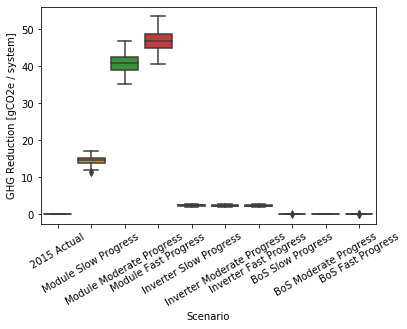

In [17]:
g = sb.boxplot(
    x="Scenario",
    y="Value",
    data=scenario_results.xs(
        ["Metric", "GHG"],
        level=["Variable", "Index"]
    ).reset_index()[["Scenario", "Value"]],
    order=[
        "2015 Actual"              ,
        "Module Slow Progress"      ,
        "Module Moderate Progress"  ,
        "Module Fast Progress"      ,
        "Inverter Slow Progress"    ,
        "Inverter Moderate Progress",
        "Inverter Fast Progress"    ,
        "BoS Slow Progress"         ,
        "BoS Moderate Progress"     ,
        "BoS Fast Progress"         ,
    ]
)
g.set(ylabel="GHG Reduction [gCO2e / system]")
g.set_xticklabels(g.get_xticklabels(), rotation=30);

### Plot LCOE metric.

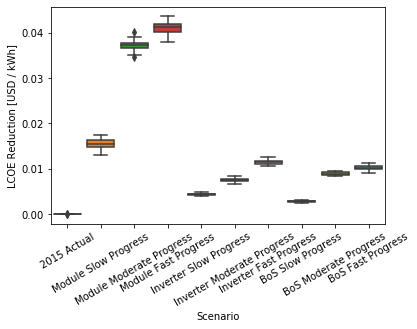

In [18]:
g = sb.boxplot(
    x="Scenario",
    y="Value",
    data=scenario_results.xs(
        ["Metric", "LCOE"],
        level=["Variable", "Index"]
    ).reset_index()[["Scenario", "Value"]],
    order=[
        "2015 Actual"              ,
        "Module Slow Progress"      ,
        "Module Moderate Progress"  ,
        "Module Fast Progress"      ,
        "Inverter Slow Progress"    ,
        "Inverter Moderate Progress",
        "Inverter Fast Progress"    ,
        "BoS Slow Progress"         ,
        "BoS Moderate Progress"     ,
        "BoS Fast Progress"         ,
    ]
)
g.set(ylabel="LCOE Reduction [USD / kWh]")
g.set_xticklabels(g.get_xticklabels(), rotation=30);

### Plot labor metric.

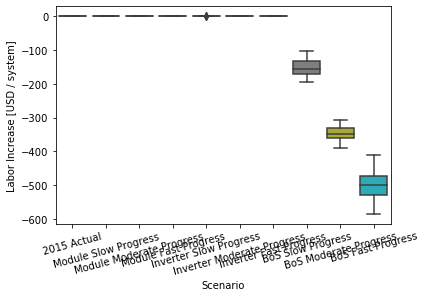

In [19]:
g = sb.boxplot(
    x="Scenario",
    y="Value",
    data=scenario_results.xs(
        ["Metric", "Labor"],
        level=["Variable", "Index"]
    ).reset_index()[["Scenario", "Value"]],
    order=[
        "2015 Actual"              ,
        "Module Slow Progress"      ,
        "Module Moderate Progress"  ,
        "Module Fast Progress"      ,
        "Inverter Slow Progress"    ,
        "Inverter Moderate Progress",
        "Inverter Fast Progress"    ,
        "BoS Slow Progress"         ,
        "BoS Moderate Progress"     ,
        "BoS Fast Progress"         ,
    ]
)
g.set(ylabel="Labor Increase [USD / system]")
g.set_xticklabels(g.get_xticklabels(), rotation=15);

## Evaluate the investments in the dataset.

In [20]:
investment_results = investments.evaluate_investments(designs, sample_count=50)

### Costs of investments.

In [21]:
investment_results.amounts

,Amount
Investment,
High R&D,8400000.0
Low R&D,2800000.0
Medium R&D,5600000.0


### Benefits of investments.

In [22]:
investment_results.metrics.xs(1, level="Sample", drop_level=False)

Value  \
Investment Category     Tranche             Scenario                   Sample Technology     Index               
Low R&D    BoS R&D      BoS Low R&D         BoS Slow Progress          1      Residential PV GHG     -0.003736   
                                                                                             LCOE     0.002792   
                                                                                             Labor -154.121648   
High R&D   Inverter R&D Inverter High R&D   Inverter Fast Progress     1      Residential PV GHG      2.222498   
                                                                                             LCOE     0.011431   
                                                                                             Labor   -0.036005   
Medium R&D Inverter R&D Inverter Medium R&D Inverter Moderate Progress 1      Residential PV GHG      2.529230   
                                                                                             LCOE     0.007250   
                                                                                             Labor    0.059053   
Low R&D    Inverter R&D Inverter Low R&D    Inverter Slow Progress     1      Residential PV GHG      2.311315   
                                                                                             LCOE     0.004397   
                                                                                             Labor   -0.015249   
High R&D   Module R&D   Module High R&D     Module Fast Progress       1      Residential PV GHG     51.608236   
                                                                                             LCOE     0.043701   
                                                                                             Labor    0.079159   
Medium R&D Module R&D   Module Medium R&D   Module Moderate Progress   1      Residential PV GHG     38.543220   
                                                                                             LCOE     0.035966   
                                                                                             Labor   -0.030530   
Low R&D    Module R&D   Module Low R&D      Module Slow Progress       1      Residential PV GHG     16.062350   
                                                                                             LCOE     0.016943   
                                                                                             Labor   -0.022079   

                                                                                                            Units  
Investment Category     Tranche             Scenario                   Sample Technology     Index                 
Low R&D    BoS R&D      BoS Low R&D         BoS Slow Progress          1      Residential PV GHG    ΔgCO2e/system  
                                                                                             LCOE          Δ$/kWh  
                                                                                             Labor      Δ$/system  
High R&D   Inverter R&D Inverter High R&D   Inverter Fast Progress     1      Residential PV GHG    ΔgCO2e/system  
                                                                                             LCOE          Δ$/kWh  
                                                                                             Labor      Δ$/system  
Medium R&D Inverter R&D Inverter Medium R&D Inverter Moderate Progress 1      Residential PV GHG    ΔgCO2e/system  
                                                                                             LCOE          Δ$/kWh  
                                                                                             Labor      Δ$/system  
Low R&D    Inverter R&D Inverter Low R&D    Inverter Slow Progress     1      Residential PV GHG    ΔgCO2e/system  
                                                                                          

In [23]:
investment_results.summary.xs(1, level="Sample", drop_level=False)

Value          Units
Investment Sample Index                           
Low R&D    1.0    GHG     18.369929  ΔgCO2e/system
                  LCOE     0.024131         Δ$/kWh
                  Labor -154.158977      Δ$/system
High R&D   1.0    GHG     53.830735  ΔgCO2e/system
                  LCOE     0.055133         Δ$/kWh
                  Labor    0.043155      Δ$/system
Medium R&D 1.0    GHG     41.072450  ΔgCO2e/system
                  LCOE     0.043216         Δ$/kWh
                  Labor    0.028523      Δ$/system

### Save results.

In [24]:
investment_results.amounts.to_csv("output/residential_pv_multiobjective/example-investment-amounts.csv")

In [25]:
investment_results.metrics.to_csv("output/residential_pv_multiobjective/example-investment-metrics.csv")

### Plot GHG metric.

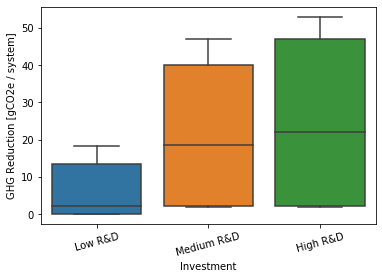

In [26]:
g = sb.boxplot(
    x="Investment",
    y="Value",
    data=investment_results.metrics.xs(
        "GHG",
        level="Index"
    ).reset_index()[["Investment", "Value"]],
    order=[
        "Low R&D"   ,
        "Medium R&D",
        "High R&D"  ,
    ]
)
g.set(ylabel="GHG Reduction [gCO2e / system]")
g.set_xticklabels(g.get_xticklabels(), rotation=15);

### Plot LCOE metric.

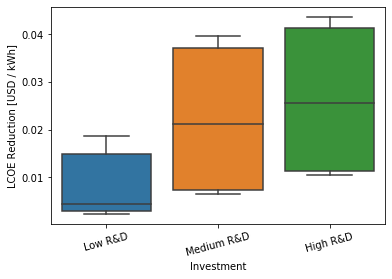

In [27]:
g = sb.boxplot(
    x="Investment",
    y="Value",
    data=investment_results.metrics.xs(
        "LCOE",
        level="Index"
    ).reset_index()[["Investment", "Value"]],
    order=[
        "Low R&D"   ,
        "Medium R&D",
        "High R&D"  ,
    ]
)
g.set(ylabel="LCOE Reduction [USD / kWh]")
g.set_xticklabels(g.get_xticklabels(), rotation=15);

### Plot labor metric.

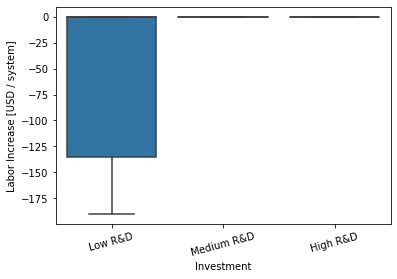

In [28]:
g = sb.boxplot(
    x="Investment",
    y="Value",
    data=investment_results.metrics.xs(
        "Labor",
        level="Index"
    ).reset_index()[["Investment", "Value"]],
    order=[
        "Low R&D"   ,
        "Medium R&D",
        "High R&D"  ,
    ]
)
g.set(ylabel="Labor Increase [USD / system]")
g.set_xticklabels(g.get_xticklabels(), rotation=15);

## Multi-objective decision analysis.

<font color="red">**THIS IS A WORK IN PROGRESS.**</font>

### Compute costs and metrics for tranches.

Tranches are atomic units for building investment portfolios. Evaluate all of the tranches, so we can assemble them into investments (portfolios).

In [29]:
tranche_results = investments.evaluate_tranches(designs, sample_count=500)

Display the cost of each tranche.

In [30]:
tranche_results.amounts

Amount
Category     Tranche                       
BoS R&D      BoS High R&D          900000.0
             BoS Low R&D           300000.0
             BoS Medium R&D        600000.0
Inverter R&D Inverter High R&D    3000000.0
             Inverter Low R&D     1000000.0
             Inverter Medium R&D  2000000.0
Module R&D   Module High R&D      4500000.0
             Module Low R&D       1500000.0
             Module Medium R&D    3000000.0

Display the metrics for each tranche.

In [31]:
tranche_results.summary

Value          Units
Category   Tranche        Sample Index                           
BoS R&D    BoS Low R&D    1.0    GHG     -0.008180  ΔgCO2e/system
                                 LCOE     0.002697         Δ$/kWh
                                 Labor -141.625878      Δ$/system
                          2.0    GHG      0.001385  ΔgCO2e/system
                                 LCOE     0.002853         Δ$/kWh
...                                            ...            ...
Module R&D Module Low R&D 499.0  LCOE     0.015400         Δ$/kWh
                                 Labor   -0.013703      Δ$/system
                          500.0  GHG     15.055054  ΔgCO2e/system
                                 LCOE     0.016352         Δ$/kWh
                                 Labor   -0.039216      Δ$/system

[10500 rows x 2 columns]

Save the results.

In [32]:
tranche_results.amounts.to_csv("output/residential_pv_multiobjective/example-tranche-amounts.csv")
tranche_results.summary.to_csv("output/residential_pv_multiobjective/example-tranche-summary.csv")

Here is an <font color="red">incomplete work-in-progress</font> on plotting metrics for tranches. <font color="red">The axis labels etc. need fixing.</font>

/nix/store/f9jr3lh0ix952h7lr0xiwq9gkl1yckk1-python3-3.6.9-env/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


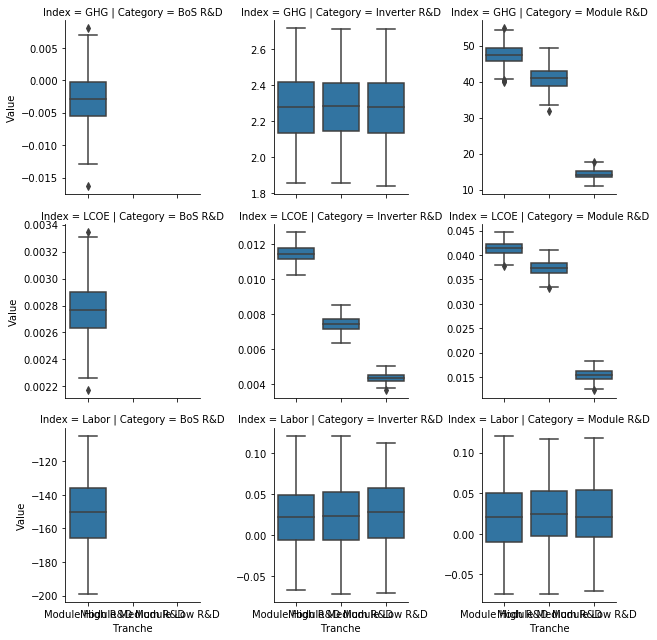

In [33]:
g = sb.FacetGrid(
    tranche_results.summary.reset_index(),#.set_index(["Category", "Tranche"])join(tranche_results.amount).reset_index(),
    row="Index",
    col="Category",
#    row_order=["LCOE", "GHG", "Labor"],
#    col_order=["Module R&D", "Inverter R&D", "BoS R&D"],
    sharex=True,
    sharey=False,
)
g.map(sb.boxplot, "Tranche", "Value")


### Compute all combinations of tranches.

#### Set up investment scenarios.

We're just building all legal combinations of tranches into investment portfolios.

In [34]:
z = None
for imod in np.append(investments.tranches.xs("Module R&D").reset_index("Scenario").index.unique().values, ""):
    for iinv in np.append(investments.tranches.xs("Inverter R&D").reset_index("Scenario").index.unique().values, ""):
        for ibos in np.append(investments.tranches.xs("BoS R&D").reset_index("Scenario").index.unique().values, ""):
            w = None
            name = imod 
            if iinv != "":
                if name != "":
                    name = name + " + "
                name = name + iinv
            if ibos != "":
                if name != "":
                    name = name + " + "
                name = name + ibos
            if imod != "":
                w = pd.DataFrame({
                    "Investment" : [name        ],
                    "Category"   : ["Module R&D"],
                    "Tranche"    : [imod        ],
                    "Notes"      : [""          ],
                }).append(w)
            if iinv != "":
                w = pd.DataFrame({
                    "Investment" : [name          ],
                    "Category"   : ["Inverter R&D"],
                    "Tranche"    : [iinv          ],
                    "Notes"      : [""            ],
                }).append(w)
            if ibos != "":
                w = pd.DataFrame({
                    "Investment" : [name     ],
                    "Category"   : ["BoS R&D"],
                    "Tranche"    : [ibos     ],
                    "Notes"      : [""       ],
                }).append(w)
            if w is not None:
                z = w.append(z)
z.set_index(["Investment", "Category", "Tranche"], inplace=True)
investments.investments = z
z

Notes
Investment                                         Category     Tranche                  
BoS Medium R&D                                     BoS R&D      BoS Medium R&D           
BoS Low R&D                                        BoS R&D      BoS Low R&D              
BoS High R&D                                       BoS R&D      BoS High R&D             
Inverter Medium R&D                                Inverter R&D Inverter Medium R&D      
Inverter Medium R&D + BoS Medium R&D               BoS R&D      BoS Medium R&D           
...                                                                                   ...
Module High R&D + Inverter High R&D + BoS Low R&D  Inverter R&D Inverter High R&D        
                                                   Module R&D   Module High R&D          
Module High R&D + Inverter High R&D + BoS High R&D BoS R&D      BoS High R&D             
                                                   Inverter R&D Inverter High R&D        
                                                   Module R&D   Module High R&D          

[144 rows x 1 columns]

#### Evaluate the investments.

In [35]:
investment_results = investments.evaluate_investments(designs, sample_count=50)

In [36]:
investment_results.amounts

,Amount
Investment,
BoS High R&D,900000.0
Inverter Medium R&D + BoS High R&D,2900000.0
Inverter Low R&D + BoS High R&D,1900000.0
Inverter High R&D + BoS High R&D,3900000.0
Module Medium R&D + BoS High R&D,3900000.0
...,...
Module Low R&D + Inverter Medium R&D,3500000.0
Module High R&D + Inverter Medium R&D,6500000.0
Module High R&D,4500000.0


In [37]:
investment_results.summary.xs(1, level="Sample", drop_level=False)

Value          Units
Investment                        Sample Index                           
BoS Low R&D                       1.0    GHG      0.000405  ΔgCO2e/system
                                         LCOE     0.002630         Δ$/kWh
                                         Labor -139.177759      Δ$/system
Inverter Medium R&D + BoS Low R&D 1.0    GHG      1.918760  ΔgCO2e/system
                                         LCOE     0.009344         Δ$/kWh
...                                                    ...            ...
Module Low R&D + BoS Medium R&D   1.0    LCOE     0.015399         Δ$/kWh
                                         Labor    0.023847      Δ$/system
Module Low R&D + BoS High R&D     1.0    GHG     14.708698  ΔgCO2e/system
                                         LCOE     0.015399         Δ$/kWh
                                         Labor    0.023847      Δ$/system

[183 rows x 2 columns]

#### Plot the results.

In [38]:
w = investment_results.summary.reset_index(
).set_index(
    ["Investment"]
).join(
    investment_results.amounts
).reset_index(
).set_index(
    ["Index"]
)
ww = investment_results.amounts.reset_index().sort_values("Amount")["Investment"]

In [39]:
sb.set(rc={'figure.figsize':(6, 10)})

##### Cost of investments.

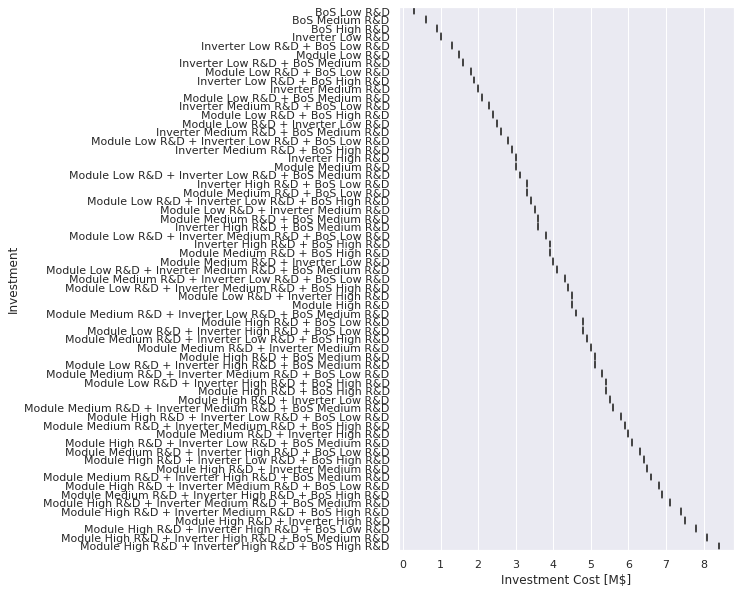

In [40]:
www = investment_results.amounts.reset_index()
www["Amount"] = www["Amount"] / 1e6
g = sb.boxplot(data=www, y="Investment", x="Amount", orient="h", order=ww)
g.set(xlabel="Investment Cost [M$]");
#pl.savefig('example-amounts.png')

#### LOCE benefits.

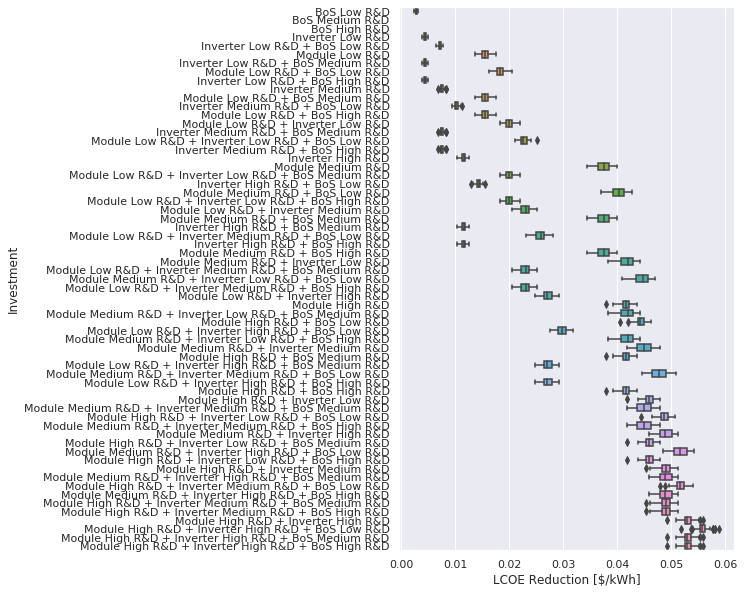

In [41]:
g = sb.boxplot(data=w.xs("LCOE"), y="Investment", x="Value", orient="h", order=ww)
g.set(xlabel="LCOE Reduction [$/kWh]");

##### GHG benefits.

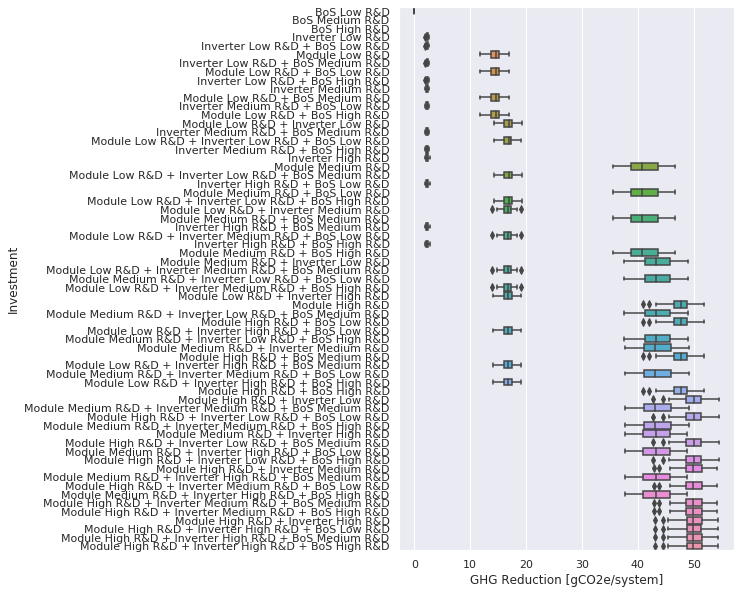

In [42]:
g = sb.boxplot(data=w.xs("GHG"), y="Investment", x="Value", orient="h", order=ww)
g.set(xlabel="GHG Reduction [gCO2e/system]");

##### Labor benefits.

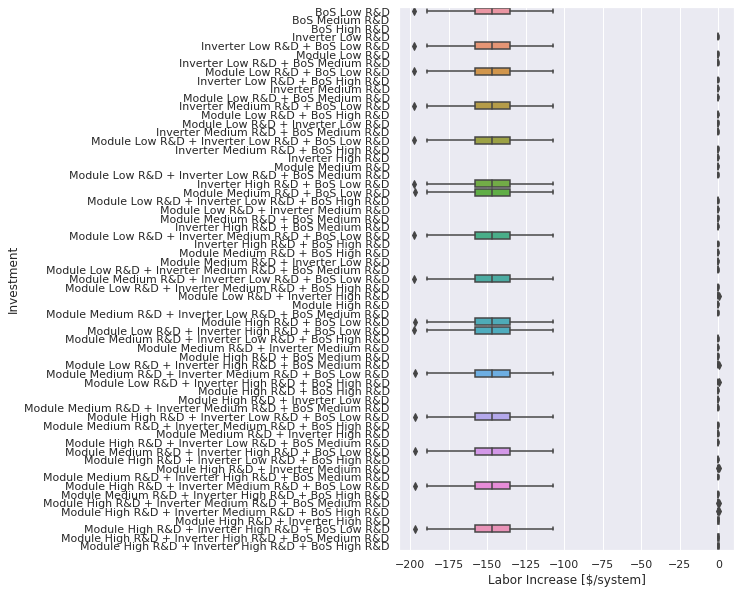

In [43]:
g = sb.boxplot(data=w.xs("Labor"), y="Investment", x="Value", orient="h", order=ww)
g.set(xlabel="Labor Increase [$/system]");